In [1]:
import sys 
sys.path.append('../scripts/')
from robot import *
from scipy.stats import multivariate_normal

In [2]:
class Particle: 
    def __init__(self, init_pose):
        self.pose = init_pose
        
    def motion_update(self, nu, omega, time, noise_rate_pdf): 
        ns = noise_rate_pdf.rvs()
        pnu = nu + ns[0]*math.sqrt(abs(nu)/time) + ns[1]*math.sqrt(abs(omega)/time)
        pomega = omega + ns[2]*math.sqrt(abs(nu)/time) + ns[3]*math.sqrt(abs(omega)/time)
        self.pose = IdealRobot.state_transition(pnu, pomega, time, self.pose)

In [3]:
class Mcl: 
    def __init__(self, init_pose, num, motion_noise_stds): 
        self.particles = [Particle(init_pose) for i in range(num)]

        v = motion_noise_stds
        c = np.diag([v["nn"]**2, v["no"]**2, v["on"]**2, v["oo"]**2])
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)
        
    def motion_update(self, nu, omega, time):
        for p in self.particles: p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)
        
    def draw(self, ax, elems):
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2]) for p in self.particles]
        vys = [math.sin(p.pose[2]) for p in self.particles] 
        elems.append(ax.quiver(xs, ys, vxs, vys, color="blue", alpha=0.5))

In [4]:
class MclAgent(Agent): ###mcl_confirmation6（1-3行目と下のセル)
    def __init__(self, time_interval, nu, omega, particle_pose, particle_num=100,\
                motion_noise_stds={"nn":0.001, "no":0.001, "on":0.13, "oo":0.001}): 
        super().__init__(nu, omega)
        self.mcl = Mcl(particle_pose, particle_num, motion_noise_stds)
        self.time_interval = time_interval
        
    def decision(self, observation=None):
        self.mcl.motion_update(self.nu, self.omega, self.time_interval)
        return self.nu, self.omega
        
    def draw(self, ax, elems):
        self.mcl.draw(ax, elems)

<IPython.core.display.Javascript object>


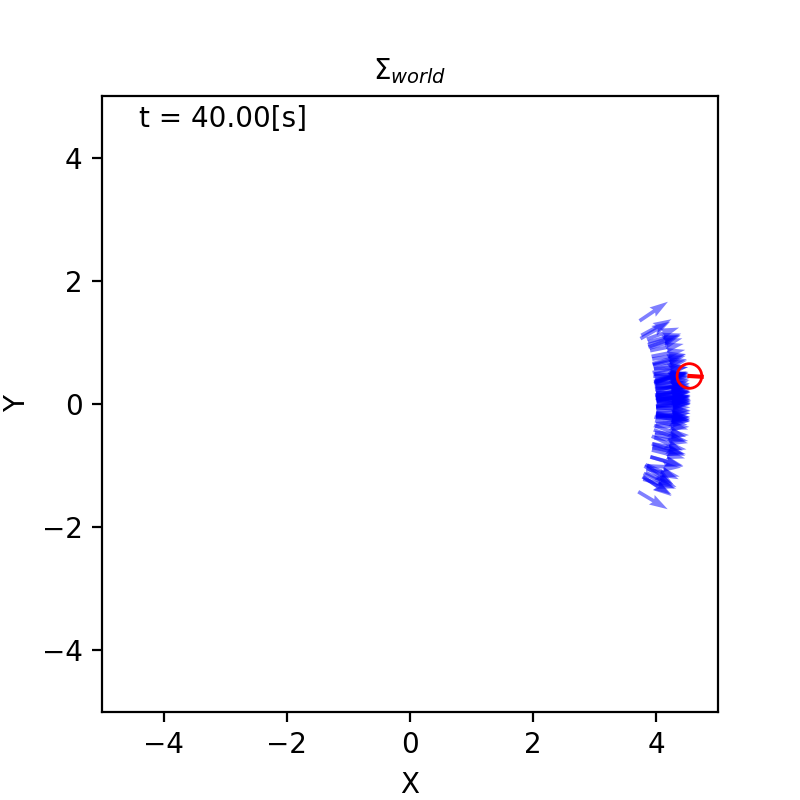

In [5]:
time_interval = 0.1
world = World(40, time_interval)

a = MclAgent(time_interval, 0.1, 0.0, np.array([0, 0, 0]).T)
r = Robot( np.array([0, 0, 0]).T, sensor=None, agent=a, color="red" )
world.append(r)

world.draw()

In [6]:
print(a.mcl.particles[0].pose)

[0 0 0]
